In [1]:
%pip install --upgrade transformers datasets accelerate deepspeed
%pip install gdown
import gdown
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
import transformers
import datasets
import numpy as np
import math
from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 86.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 40.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.3 MB/s eta 0:00:00
  Created wheel for deepspeed: filename=deepspeed-0.14.4-py3-none-any.whl size=1445501 sha256=4b68adc510a783d9e5ebfc535dde1fcdfa73b8ba9d8da5d767826633972e247d
  Stored in directory: /root/.cache/pip/wheels/8e/bc/a3/608e90bbb301848b78fd75d24d6d43ba3074de968fc0e397ac
Successfully built deepspeed
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
  

In [3]:
import random
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)

In [4]:
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


# Deberta

In [5]:
class DebertaEmbeddings(nn.Module):
  def __init__(self, config):
    super(DebertaEmbeddings, self).__init__()

    self.vocab_size = config.vocab_size
    self.embedding_size = getattr(config, 'embedding_size', config.hidden_size)

    self.word_embeddings = nn.Embedding(self.vocab_size, self.embedding_size,
                                        padding_idx=config.pad_token_id)

    self.type_vocab_size = config.type_vocab_size

    if self.type_vocab_size > 0:
      self.token_type_embeddings = nn.Embedding(self.type_vocab_size,
                                                self.embedding_size)

    self.LayerNorm = nn.LayerNorm(self.embedding_size, config.layer_norm_eps)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)

  def forward(self, input_ids, token_type_ids=None, mask = None):
    embeddings = self.word_embeddings(input_ids)

    if token_type_ids is None:
      token_type_ids = torch.zeros_like(input_ids)

    if self.type_vocab_size > 0:
      token_type_embeddings = self.token_type_embeddings(token_type_ids)
      embeddings += token_type_embeddings

    mask = mask.unsqueeze(-1)

    embeddings = embeddings * mask
    embeddings = self.LayerNorm(embeddings)
    embeddings = self.dropout(embeddings)

    return embeddings

class DebertaSelfOutput(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.hidden_size = config.hidden_size
    self.layer_norm_eps = config.layer_norm_eps
    self.hidden_dropout_prob = config.hidden_dropout_prob

    self.dense = nn.Linear(self.hidden_size, self.hidden_size)
    self.LayerNorm = nn.LayerNorm(self.hidden_size, self.layer_norm_eps)
    self.dropout = nn.Dropout(self.hidden_dropout_prob)

  def forward(self, hidden_states, input_states):
    hidden_states = self.dense(hidden_states)
    hidden_states = self.dropout(hidden_states)
    hidden_states += input_states
    hidden_states = self.LayerNorm(hidden_states)

    return hidden_states

class DebertaIntermediate(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
    self.intermediate_act_fn = nn.GELU()

  def forward(self, hidden_states):
    hidden_states = self.dense(hidden_states)
    hidden_states = self.intermediate_act_fn(hidden_states)

    return hidden_states

class DebertaOutput(nn.Module):
  def __init__(self, config):
    super(DebertaOutput, self).__init__()

    self.hidden_size = config.hidden_size
    self.intermediate_size = config.intermediate_size
    self.hidden_dropout_prob = config.hidden_dropout_prob
    self.layer_norm_eps = config.layer_norm_eps

    self.dense = nn.Linear(self.intermediate_size, self.hidden_size)
    self.LayerNorm = nn.LayerNorm(self.hidden_size, self.layer_norm_eps)
    self.dropout = nn.Dropout(self.hidden_dropout_prob)

  def forward(self, hidden_states, input_states):
    hidden_states = self.dense(hidden_states)
    hidden_states = self.dropout(hidden_states)
    hidden_states +=  input_states
    hidden_states = self.LayerNorm(hidden_states)

    return hidden_states

class DisentangledSelfAttention(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.hidden_size = config.hidden_size
    self.num_attention_heads = config.num_attention_heads
    self.head_size = int(self.hidden_size/self.num_attention_heads)

    self.query_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=True)
    self.key_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
    self.value_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=True)

    self.pos_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
    self.pos_q_proj = nn.Linear(self.hidden_size, self.hidden_size)

    self.pos_dropout = nn.Dropout(config.hidden_dropout_prob)
    self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

  def reshape_states(self, x, size):

    return x.view(*x.shape[:-1], self.num_attention_heads, size).transpose(-2, -3)

  def forward(self, hidden_states, attention_mask, relative_pos, rel_embeddings, query_states=None):

    """
    param hidden_states: exit from the previous layer, float32[batch_size, seq_length, hidden_size]
    param attention_mask: bool[batch_size, 1, seq_length, seq_length]
    param relative_pos: relative distance matrix, int64[seq_length, seq_length]
    param rel_embeddings: relative position embedding vectors, float32[2*position_buckets, hidden_size]
    param query_states: information for decoding (e.g. hidden states, absolute position embedding
    or output from the previous ENHANCED MASK DECODER layer), float32[batch_size, seq_length, hidden_size]
    """

    if query_states is None:
      query_states = hidden_states

    query = self.query_proj(query_states) #[batch_size, num_heads, seq_len, head_size]
    key = self.key_proj(hidden_states)
    value =  self.value_proj(hidden_states)

    query, key, value =  self.reshape_states(torch.cat((query, key, value), dim=-1), 3*self.head_size).split(self.head_size, dim=-1)

    rel_embeddings = self.pos_dropout(rel_embeddings)
    pos_query = self.reshape_states(self.pos_q_proj(rel_embeddings), self.head_size)  #[num_heads, 2*position_buckets, head_size]
    pos_key = self.reshape_states(self.pos_proj(rel_embeddings), self.head_size)

    #context to context score
    c2c_score = query @ key.transpose(-1, -2)  #[batch_size, num_heads, seq_len, seq_len]

    #context to position score
    c2p_score = query @ pos_key.transpose(-1, -2)  #[batch_size, num_heads, seq_len, 2*position_buckets]
    c2p_pos = relative_pos.expand(*c2p_score.size()[:2], -1, -1)
    c2p_score = torch.gather(c2p_score, dim=-1, index = c2p_pos)

    #position to context score
    p2c_score = key @ pos_query.transpose(-1, -2)
    p2c_score = torch.gather(p2c_score, dim=-1, index = c2p_pos.transpose(-1, -2))
    p2c_score = p2c_score.transpose(-1, -2)

    #accamulate attention scores
    scale_factor = 1/math.sqrt(query.size(-1) * 3)
    score = (c2c_score + c2p_score + p2c_score) * scale_factor

    mask = ~(attention_mask)  #we do not pay attention to invalid tokens
    score = score.masked_fill(mask, float('-inf'))
    score = torch.softmax(score, dim = -1)
    score = score.masked_fill(mask, 0)
    score = self.dropout(score)
    score = score @ value
    score = score.transpose(1, 2)
    score_shape = score.shape

    hidden_states = score.reshape(*score_shape[:-2], score_shape[-2] * score_shape[-1])

    return hidden_states

class DebertaAttention(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.self = DisentangledSelfAttention(config)
    self.output = DebertaSelfOutput(config)

  def forward(self, hidden_states, attention_mask, relative_pos, rel_embeddings, query_states=None):

    input_states = hidden_states

    hidden_states = self.self(hidden_states, attention_mask, relative_pos, rel_embeddings, query_states)

    attention_output = self.output(hidden_states, input_states)

    return attention_output

class DebertaLayer(nn.Module):
  def __init__(self, config):
    super(DebertaLayer, self).__init__()

    self.attention = DebertaAttention(config)
    self.intermediate = DebertaIntermediate(config)
    self.output = DebertaOutput(config)

  def forward(self, hidden_states, attention_mask, relative_pos, rel_embeddings, query_states=None):

    attention_output = self.attention(hidden_states, attention_mask, relative_pos, rel_embeddings, query_states)
    intermediate_output = self.intermediate(attention_output)
    output = self.output(intermediate_output, attention_output)

    return output

class DebertaEncoder(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.layer = nn.ModuleList([DebertaLayer(config) for _ in range(config.num_hidden_layers)])
    self.pos_ebd_size = config.max_position_embeddings
    self.hidden_size = config.hidden_size

    self.rel_embeddings = nn.Embedding(self.pos_ebd_size * 2, self.hidden_size)

  def get_attention_mask(self, attention_mask):
    ext_attention_mask = attention_mask.unsqueeze(-1).to(torch.float)
    ext_attention_mask = ext_attention_mask @ ext_attention_mask.transpose(-1, -2)
    return ext_attention_mask.unsqueeze(1).to(torch.bool)

  def create_distance_matrix(self, seq_len: int, max_distance: int):
    indices = torch.arange(seq_len)
    indices_t = indices.unsqueeze(-1)
    diff_indcs = indices_t - indices
    dis_mat = diff_indcs
    k = max_distance

    dis_mat[diff_indcs >= k] = 2 * k - 1
    dis_mat[torch.logical_and(-k < diff_indcs, diff_indcs < k)] += k
    dis_mat[diff_indcs <= -k] = 0

    return dis_mat.to(torch.int64)

  def forward(self, hidden_states, attention_mask, query_states = None, relative_pos=None):

    rel_embeddings = self.rel_embeddings.weight
    attention_mask = self.get_attention_mask(attention_mask)
    relative_pos = self.create_distance_matrix(hidden_states.shape[1],
                                               self.pos_ebd_size).to(hidden_states.device)

    for layer in self.layer:
      output_states = layer(hidden_states, attention_mask, relative_pos, rel_embeddings, query_states)
      hidden_states = output_states
      if query_states is not None:
        query_states = output_states

    return hidden_states

class DebertaModel(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.embeddings = DebertaEmbeddings(config)
    self.encoder = DebertaEncoder(config)

  def forward(self, input_ids, attention_mask, token_type_ids = None):

    embeddings = self.embeddings(input_ids, token_type_ids, attention_mask)
    encoder_output = self.encoder(embeddings, attention_mask)

    return encoder_output

In [6]:
pre_config = transformers.PretrainedConfig()
config = pre_config.from_json_file('deberta_config.json')

In [7]:
deberta = DebertaModel(config).to(device)

In [8]:
pretrained_deberta = transformers.AutoModel.from_pretrained('microsoft/deberta-base')

from collections import OrderedDict
state_dict = pretrained_deberta.state_dict()

new_state_dict = OrderedDict()
for key, value in tuple(state_dict.items()):
  if 'deberta.' in key:
    key = key.replace('deberta.', "")
  if 'q_bias' in key:
    key = key.replace('q_bias', 'query_proj.bias')
  if 'v_bias' in key:
    key = key.replace('v_bias', 'value_proj.bias')
  if 'in_proj' in key:
    q, k, v = value.split(config.hidden_size, dim=-2)
    key_q = key.replace('in_proj', 'query_proj')
    key_k = key.replace('in_proj', 'key_proj')
    key_v = key.replace('in_proj', 'value_proj')

    new_state_dict[key_q] = q
    new_state_dict[key_k] = k
    new_state_dict[key_v] = v
    continue
  new_state_dict[key] = value

del pretrained_deberta

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
deberta.load_state_dict(new_state_dict)

for i, param in enumerate(deberta.parameters()):
    param.requires_grad = False

print("Total trainable params: ", sum(p.numel() for p in deberta.parameters() if p.requires_grad))

Total trainable params:  0


# Add LoRa

In [10]:
class LoRALayer(nn.Module):
    def __init__(self, module:nn.Linear, rank):
        super().__init__()

        self.module = module

        self.adapter_A = nn.Parameter(torch.rand(module.in_features, rank, device = module.weight.device))
        self.adapter_B = nn.Parameter(torch.zeros(rank, module.out_features, device = module.weight.device))

    def forward(self, input):
        return self.module(input) + (input @ self.adapter_A) @ self.adapter_B

In [11]:
lora_rank = 32

for layer_name, module in deberta.named_modules():
    if 'DebertaAttention' in repr(type(module)):
        module.self.query_proj = LoRALayer(module.self.query_proj, lora_rank)
        module.self.key_proj = LoRALayer(module.self.key_proj, lora_rank)
        module.self.value_proj = LoRALayer(module.self.value_proj, lora_rank)

assert sum(isinstance(module, LoRALayer) for module in deberta.modules()) == 12*3

# Q&A Deberta

In [12]:
class DebertaQA(nn.Module):
  def __init__(self, deberta, deberta_config):
    super().__init__()

    hidden_size = deberta_config.hidden_size
    self.deberta = deberta
    self.gelu = nn.GELU()

    self.linear1 = nn.Linear(hidden_size, 2)

  def forward(self, input_ids, token_type_ids, attention_mask):
    res = self.deberta(input_ids = input_ids,
                       token_type_ids = token_type_ids,
                       attention_mask = attention_mask)

    res = self.gelu(res)
    res = self.linear1(res)

    start, end = torch.split(res, 1, dim = -1)

    return start.squeeze(-1), end.squeeze(-1)

In [13]:
def compute_loss(start_logits, end_logits, start_pos, end_pos, loss_with_logits):

  num_cls = start_logits.shape[1]
  start_gt = F.one_hot(start_pos, num_classes = num_cls)
  end_gt = F.one_hot(end_pos, num_classes = num_cls)

  start_loss = loss_with_logits(start_logits, start_gt.float())
  end_loss = loss_with_logits(end_logits, end_gt.float())

  return (start_loss + end_loss)/2

In [14]:
def BCEWithLogits(pred, target):
  res = -F.log_softmax(pred, dim=-1)
  res *= target
  res = torch.sum(res)/len(pred)
  return res

In [15]:
def f1_score(pred_ans, target_ans):
  """
  pred_ans: list - prediction answer tokens
  target_ans: list - correct answer tokens
  """
  epsilon = 1e-6

  num_same = len(set(pred_ans) & set(target_ans))
  len_pred = len(pred_ans)
  len_target = len(target_ans)


  if len_pred == 0 or len_target == 0:
    f1 = int(len_pred == len_target)
  else:
    precision = num_same / len_pred
    recall = num_same / len_target

    f1 = 2 * precision * recall / (precision + recall + epsilon)

  return f1

In [16]:
def compute_score(input_ids, start_logits, end_logits, start_pos, end_pos, score):
  start_pred = torch.argmax(start_logits, dim = -1).squeeze(0)
  end_pred = torch.argmax(end_logits, dim = -1).squeeze(0)

  batch_size = len(input_ids)

  total_score = 0

  for i in range(batch_size):
    predict_ids = input_ids[i][start_pred[i]:end_pred[i]+1]
    gt_ids = input_ids[i][start_pos[i]:end_pos[i]+1]

    total_score += score(predict_ids.tolist(), gt_ids.tolist())

  return total_score/batch_size

# Loading and processing data

In [17]:
model_name = "microsoft/deberta-base"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
from datasets import load_dataset
squad_train = load_dataset("squad", split="train[0:10000]")
squad_test = load_dataset("squad", split="validation[:1000]")

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [19]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True, # (start, end) - начало и конец токена в тексте
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    return inputs

In [20]:
preproc_train = squad_train.map(preprocess_function, batched=True, remove_columns=squad_train.column_names)
preproc_test = squad_test.map(preprocess_function, batched=True, remove_columns=squad_test.column_names)

preproc_train.set_format(type='torch', columns = preproc_train.column_names)
preproc_test.set_format(type='torch', columns = preproc_test.column_names)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Train and eval

In [21]:
batch_size = 16
train_dataloader = DataLoader(preproc_train, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(preproc_test, batch_size = batch_size, shuffle = False)

model = DebertaQA(deberta, config).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00001)


total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
p_trainable_params = round(trainable_params / total_params, 3) * 100

print(f"Total params: {total_params} | Trainable params: {trainable_params} | Percentage of trainable params: {p_trainable_params}%")

Total params: 140372738 | Trainable params: 1771010 | Percentage of trainable params: 1.3%


In [22]:
def train(model, criterion, optimizer, score, dataloader):
  total_loss = 0
  total_score = 0

  model.train(True)
  for batch in tqdm(dataloader):
    optimizer.zero_grad()

    input_ids = batch['input_ids'].to(device)
    token_type_ids = batch['token_type_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    start_pos = batch['start_positions']
    end_pos = batch['end_positions']

    start, end = model(input_ids = input_ids,
                       token_type_ids = token_type_ids,
                       attention_mask = attention_mask)

    loss = compute_loss(start.cpu(), end.cpu(),
                        start_pos, end_pos, criterion)

    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    total_score += compute_score(input_ids.cpu(),  start.cpu(), end.cpu(),
                                   start_pos, end_pos, score)

  return total_loss/len(dataloader), total_score/len(dataloader)

In [23]:
def eval(model, criterion, score, dataloader):
  total_loss = 0
  total_score = 0

  model.eval()
  with torch.no_grad():
    for batch in tqdm(dataloader):

      input_ids = batch['input_ids'].to(device)
      token_type_ids = batch['token_type_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)

      start_pos = batch['start_positions']
      end_pos = batch['end_positions']

      start, end = model(input_ids = input_ids,
                       token_type_ids = token_type_ids,
                       attention_mask = attention_mask)

      total_loss += compute_loss(start.cpu(), end.cpu(),
                                 start_pos, end_pos, criterion).item()

      total_score += compute_score(input_ids.cpu(),  start.cpu(), end.cpu(),
                                   start_pos, end_pos, score)

  return total_loss/len(dataloader), total_score/len(dataloader)

In [24]:
#BEFORE TRAINING

train_loss, train_score = eval(model, BCEWithLogits, f1_score, train_dataloader)
test_loss, test_score = eval(model, BCEWithLogits, f1_score, test_dataloader)

loss_history_train = [train_loss]
loss_history_test = [test_loss]

score_history_train = [round(train_score * 100, 2)]
score_history_test = [round(test_score * 100, 2)]

100%|██████████| 63/63 [00:21<00:00,  2.97it/s]


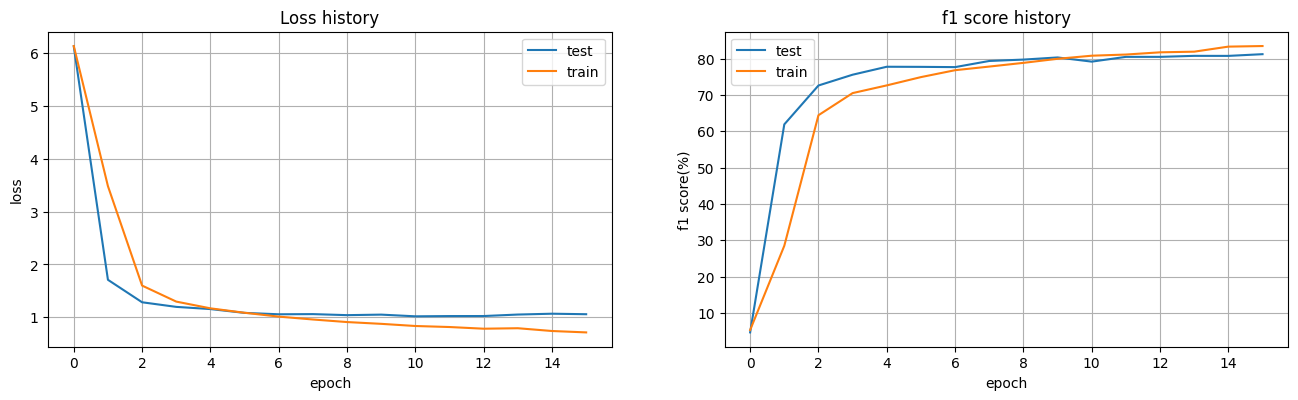

In [25]:
num_epoch = 15

for epoch in range(1, num_epoch + 1):
  train_loss, train_score = train(model, BCEWithLogits, optimizer, f1_score, train_dataloader)
  test_loss, test_score = eval(model, BCEWithLogits, f1_score, test_dataloader)

  loss_history_train.append(train_loss)
  loss_history_test.append(test_loss)

  score_history_train.append(round(train_score * 100, 2))
  score_history_test.append(round(test_score * 100, 2))

  clear_output(True)
  plt.figure(figsize=(16, 9))
  plt.subplot(2, 2, 1)
  plt.title("Loss history")
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.plot(list(range(epoch+1)), loss_history_test, label = "test")
  plt.plot(list(range(epoch+1)), loss_history_train, label = "train")
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend()
  plt.grid()

  plt.subplot(2, 2, 2)
  plt.title("f1 score history")
  plt.ylabel("f1 score(%)")
  plt.xlabel("epoch")
  plt.plot(list(range(epoch+1)), score_history_test, label = "test")
  plt.plot(list(range(epoch+1)), score_history_train, label = "train")
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend() 
  plt.grid()
    
  plt.show()

In [26]:
print(f"Final test f1 score: {score_history_test[-1]}%")

Final test f1 score: 81.22%


In [27]:
torch.save(model.state_dict(), 'deberta_qa_weights.pth')

In [28]:
from IPython.display import FileLink
FileLink('deberta_qa_weights.pth')

/kaggle/working/deberta_qa_weights.pth

# Q&A Examples

In [29]:
def answer_the_question(model, input_ids, token_type_ids, attention_mask, start_pos, end_pos, score):

    model.eval()

    start, end = model(input_ids = input_ids,
                       token_type_ids = token_type_ids,
                       attention_mask = attention_mask)

    start_pred = torch.argmax(start, dim = -1).squeeze(0)
    end_pred = torch.argmax(end, dim = -1).squeeze(0)

    predict_ids = []
    gt_ids = []
    final_scores = []

    for i in range(len(input_ids)):
        predict_ids_i = input_ids[i][start_pred[i]:end_pred[i]+1]
        gt_ids_i = input_ids[i][start_pos[i]:end_pos[i]+1]
        score_i = score(predict_ids_i.tolist(), gt_ids_i.tolist())

        predict_ids.append(predict_ids_i)
        gt_ids.append(gt_ids_i)
        final_scores.append(score_i)

    return predict_ids, gt_ids, final_scores

In [36]:
examples = preproc_test[256:258]

input_ids = examples['input_ids'].to(device)
token_type_ids = examples['token_type_ids'].to(device)
attention_mask = examples['attention_mask'].to(device)

start_pos = examples['start_positions']
end_pos = examples['end_positions']

pred_ans, gt_ans, scores = answer_the_question(model, input_ids, token_type_ids, attention_mask, start_pos, end_pos, f1_score)

for i in range(len(input_ids)):
    print(f"Text: {tokenizer.decode(input_ids[i])} \n")
    print(f"Predicted answer: {tokenizer.decode(pred_ans[i])} \n")
    print(f"Ground truth answer: {tokenizer.decode(gt_ans[i])} \n")
    print(f"F1 score: {round(scores[i] * 100, 2)} %")
    print(f"-----------------------------------------")

Text: [CLS]What is the name of the Bronco's head coach, who was hired after John Fox?[SEP]Following their loss in the divisional round of the previous season's playoffs, the Denver Broncos underwent numerous coaching changes, including a mutual parting with head coach John Fox (who had won four divisional championships in his four years as Broncos head coach), and the hiring of Gary Kubiak as the new head coach. Under Kubiak, the Broncos planned to install a run-oriented offense with zone blocking to blend in with quarterback Peyton Manning's shotgun passing skills, but struggled with numerous changes and injuries to the offensive line, as well as Manning having his worst statistical season since his rookie year with the Indianapolis Colts in 1998, due to a plantar fasciitis injury in his heel that he had suffered since the summer, and the simple fact that Manning was getting old, as he turned 39 in the 2015 off-season. Although the team had a 7–0 start, Manning led the NFL in intercep